<a href="https://colab.research.google.com/github/olavodd42/gpt_ed_assistant/blob/main/notebooks/train_biobert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!/usr/bin/env python3
from datasets import Dataset, DatasetDict
from transformers import (AutoTokenizer, AutoModelForSequenceClassification,
                          TrainingArguments, Trainer, DataCollatorWithPadding)
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score, f1_score
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
from torch.nn import CrossEntropyLoss

# from datasets import DatasetDict, Dataset
# from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
# from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score, f1_score
import numpy as np
import pandas as pd
import torch
import wandb
import os
%matplotlib inline

MODEL_NAME = "emilyalsentzer/Bio_ClinicalBERT"   # seguro p/ T4. (BioGPT-Large costuma estourar VRAM)
TEXT_COL   = "text_labs"                         # ou "text_full"
TARGET     = "outcome_critical"                  # ou "outcome_ed_los"
MAX_LEN    = 256                                 # pode testar 320/384 se couber
EPOCHS     = 6                                   # 5–8 p/ convergir melhor
LR         = 2e-5
WARMUP     = 0.1                                 # 10% dos steps
WEIGHT_DEC = 0.01
SEED       = 42

# --- 0) paths ---
TR = "train_linearized.csv"
VA = "valid_linearized.csv"
TE = "test_linearized.csv"

TEXT_COL = "text_labs"            # ou "text_full"
TARGET   = "outcome_critical"     # ou "outcome_ed_los"

# --- 1) carregar CSVs e selecionar colunas ---
train_df = pd.read_csv(TR)[[TEXT_COL, TARGET]].rename(columns={TARGET: "labels"})
valid_df = pd.read_csv(VA)[[TEXT_COL, TARGET]].rename(columns={TARGET: "labels"})
test_df  = pd.read_csv(TE)[[TEXT_COL, TARGET]].rename(columns={TARGET: "labels"})

torch.backends.cuda.matmul.allow_tf32 = True
if hasattr(torch, "set_float32_matmul_precision"):
    torch.set_float32_matmul_precision("high")  # usa TF32 quando possível

os.environ["WANDB_PROJECT"] = "mimic-ed-nlp"
os.environ["WANDB_RUN_GROUP"] = "bioclinicalbert_t4"
os.environ["WANDB_LOG_MODEL"] = "false"

train_df.shape

(28002, 2)

In [ ]:
# garantir tipo int para labels
for df in (train_df, valid_df, test_df):
    df["labels"] = df["labels"].astype(int)
# antes de criar o Dataset, duplique positivos no train_df
pos = train_df[train_df["labels"]==1]
k = max(1, int((len(train_df)-len(pos))/max(1,len(pos)) // 3))  # ~triplica positivos
train_df_bal = pd.concat([train_df, *([pos]*k)], ignore_index=True).sample(frac=1, random_state=42)

ds = DatasetDict({
    "train": Dataset.from_pandas(train_df_bal, preserve_index=False),
    "validation": Dataset.from_pandas(valid_df, preserve_index=False),
    "test": Dataset.from_pandas(test_df, preserve_index=False),
})

In [ ]:
# --- 2) tokenizer/model ---
model_ckpt = "emilyalsentzer/Bio_ClinicalBERT"  # pode trocar por "microsoft/BioGPT-Large" (exige GPU maior)
tokenizer = AutoTokenizer.from_pretrained(model_ckpt, use_fast=True)

def tok(batch):
    return tokenizer(batch[TEXT_COL], truncation=True, max_length=MAX_LEN)

collator = DataCollatorWithPadding(tokenizer=tokenizer, pad_to_multiple_of=8)

ds_tok = ds.map(tok, batched=True, remove_columns=[TEXT_COL])

# remover coluna de texto para não confundir o Trainer|
# setar formato PyTorch
ds_tok = ds_tok.with_format("torch")

Map:   0%|          | 0/33894 [00:00<?, ? examples/s]

Map:   0%|          | 0/3500 [00:00<?, ? examples/s]

Map:   0%|          | 0/3500 [00:00<?, ? examples/s]

In [ ]:

# --- 3) modelo ---
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)

pos = int((ds_tok["train"]["labels"] == 1).sum().item() if hasattr(ds_tok["train"]["labels"], "sum") else (train_df["labels"]==1).sum())
neg = int((ds_tok["train"]["labels"] == 0).sum().item() if hasattr(ds_tok["train"]["labels"], "sum") else (train_df["labels"]==0).sum())
w_pos = float(neg / max(1, pos))   # peso da classe positiva

class WeightedTrainer(Trainer):
    def compute_loss(
        self,
        model,
        inputs,
        return_outputs: bool = False,
        num_items_in_batch: int | None = None,   # <-- aceita o novo argumento
        **kwargs,                                 # <-- proteção futura
    ):
        labels = inputs.get("labels")
        # forward (retorna logits)
        outputs = model(**{k: v for k, v in inputs.items() if k != "labels"})
        logits = outputs.logits  # [B, 2]

        # pesos de classe no device correto
        weight = torch.tensor([1.0, w_pos], device=logits.device, dtype=logits.dtype)
        loss_fct = CrossEntropyLoss(weight=weight)
        loss = loss_fct(logits.view(-1, 2), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# --- 4) métricas ---
def compute_metrics(p):
    logits, labels = p
    if not isinstance(logits, np.ndarray):
        logits = logits.astype(np.float32)
    probs = logits[:, 1]
    preds = (probs >= 0.5).astype(int)
    out = {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds),
    }
    # Protege quando só tem uma classe no batch/val
    if len(np.unique(labels)) == 2:
        out["roc_auc"] = roc_auc_score(labels, probs)
        out["auprc"] = average_precision_score(labels, probs)
    else:
        out["roc_auc"] = float("nan")
        out["auprc"] = float("nan")
    return out

In [ ]:
PER_DEV_TRAIN_BS = 16
PER_DEV_EVAL_BS  = 64
GRAD_ACCUM_STEPS = 2

# --- 5) treino ---
args = TrainingArguments(
    output_dir="./results",
    eval_strategy="steps",
    eval_steps=500,
    save_strategy="steps",
    save_steps=500,
    save_total_limit=2,
    logging_steps=50,
    learning_rate=LR,
    num_train_epochs=EPOCHS,
    weight_decay=WEIGHT_DEC,
    warmup_ratio=WARMUP,
    per_device_train_batch_size=PER_DEV_TRAIN_BS,
    per_device_eval_batch_size=PER_DEV_EVAL_BS,
    gradient_accumulation_steps=GRAD_ACCUM_STEPS,
    fp16=True,
    gradient_checkpointing=True,
    lr_scheduler_type="linear",
    report_to="wandb",
    run_name="bioclinicalbert_ed",
    load_best_model_at_end=True,
    metric_for_best_model="roc_auc",
    greater_is_better=True,
    dataloader_num_workers=2,
    dataloader_pin_memory=True,
    seed=SEED,
)

trainer = WeightedTrainer(
    model=model,
    args=args,
    train_dataset=ds_tok["train"],
    eval_dataset=ds_tok["validation"],
    processing_class=tokenizer,
    data_collator=collator,
    compute_metrics=compute_metrics,
)

trainer.train()
print("\n=== VALID ===")
print(trainer.evaluate(ds_tok["validation"]))
print("\n=== TEST ===")
print(trainer.evaluate(ds_tok["test"]))


Step,Training Loss,Validation Loss,Accuracy,F1,Roc Auc,Auprc
500,0.532400,0.715113,0.681429,0.300940,0.693323,0.253750
1000,0.512700,0.665245,0.789714,0.353251,0.727959,0.294776
1500,0.524300,0.633507,0.812000,0.351085,0.739675,0.315819
2000,0.498400,0.643409,0.829429,0.372240,0.738552,0.327347
2500,0.478400,0.625285,0.830286,0.358531,0.744484,0.334310
3000,0.475600,0.663818,0.787429,0.356401,0.745098,0.336901
3500,0.411500,0.703018,0.818857,0.350410,0.731880,0.318989
4000,0.376000,0.767083,0.801714,0.353818,0.722235,0.311257
4500,0.327000,0.847303,0.774571,0.339749,0.719919,0.303967
5000,0.333100,0.927015,0.784000,0.327402,0.713688,0.291018



=== VALID ===


{'eval_loss': 0.6638182997703552, 'eval_accuracy': 0.7874285714285715, 'eval_f1': 0.356401384083045, 'eval_roc_auc': 0.7450981000965632, 'eval_auprc': 0.336900702242521, 'eval_runtime': 11.4929, 'eval_samples_per_second': 304.535, 'eval_steps_per_second': 4.786, 'epoch': 6.0}

=== TEST ===
{'eval_loss': 0.6487222909927368, 'eval_accuracy': 0.8114285714285714, 'eval_f1': 0.3761814744801512, 'eval_roc_auc': 0.7665826918709685, 'eval_auprc': 0.3559354992323588, 'eval_runtime': 11.9628, 'eval_samples_per_second': 292.574, 'eval_steps_per_second': 4.598, 'epoch': 6.0}


In [ ]:
import numpy as np
from sklearn.metrics import f1_score, precision_recall_curve, classification_report, confusion_matrix

# probs e rótulos na validação
pred_val = trainer.predict(ds_tok["validation"])
probs_val = pred_val.predictions[:, 1]
y_val = pred_val.label_ids

# varre thresholds e pega o melhor F1
ths = np.linspace(0.01, 0.99, 99)
f1s = []
for th in ths:
    f1s.append(f1_score(y_val, (probs_val >= th).astype(int)))
best_idx = int(np.argmax(f1s))
best_th = ths[best_idx]
print(f"Melhor threshold (valid) p/ F1: {best_th:.2f} | F1={f1s[best_idx]:.3f}")

# Curva PR (guarde p/ relatório)
prec, rec, pr_ths = precision_recall_curve(y_val, probs_val)
print(f"PR | AP (AUPRC)≈{np.trapz(prec, rec):.3f}")

# aplica no TEST
pred_test = trainer.predict(ds_tok["test"])
probs_test = pred_test.predictions[:, 1]
y_test = pred_test.label_ids
y_pred = (probs_test >= best_th).astype(int)

print(classification_report(y_test, y_pred, digits=3))
print("Matriz de confusão (test):\n", confusion_matrix(y_test, y_pred))


Melhor threshold (valid) p/ F1: 0.76 | F1=0.375
PR | AP (AUPRC)≈-0.336


/tmp/ipython-input-1011232525.py:20: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  print(f"PR | AP (AUPRC)≈{np.trapz(prec, rec):.3f}")


              precision    recall  f1-score   support

           0      0.930     0.887     0.908      3122
           1      0.323     0.444     0.374       378

    accuracy                          0.839      3500
   macro avg      0.626     0.666     0.641      3500
weighted avg      0.864     0.839     0.850      3500

Matriz de confusão (test):
 [[2770  352]
 [ 210  168]]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!cp -r results /content/drive/MyDrive/results

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


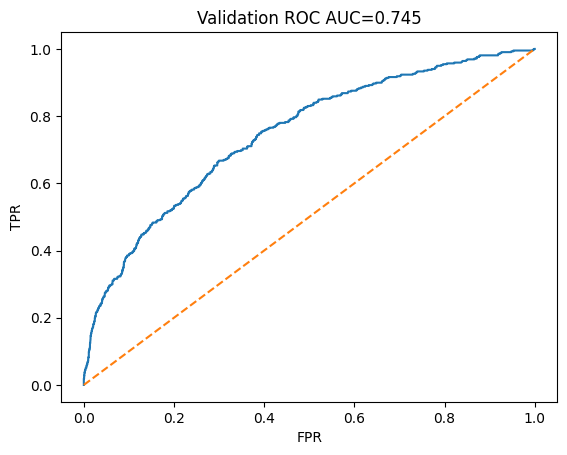

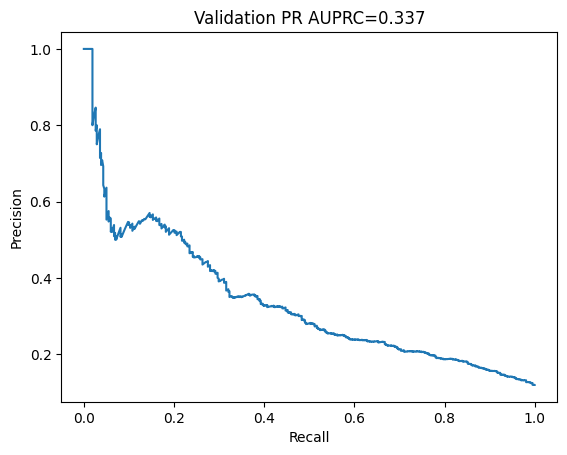

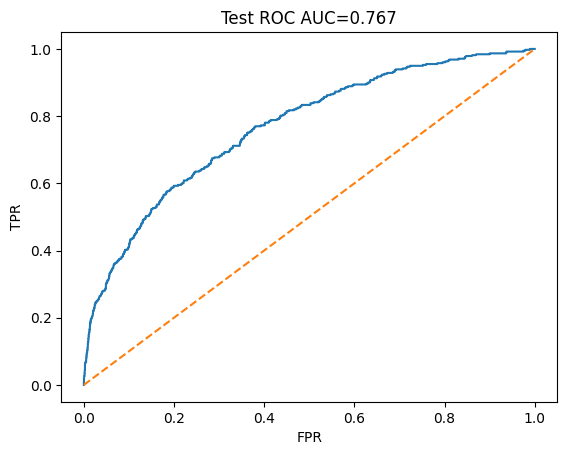

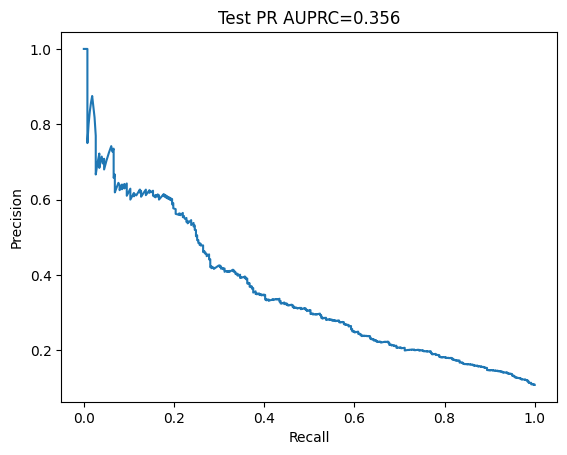

In [ ]:
def plot_roc_pr(y_true, probs, title_prefix):
    fpr, tpr, _ = roc_curve(y_true, probs); roc_auc = auc(fpr, tpr)
    prec, rec, _ = precision_recall_curve(y_true, probs); ap = average_precision_score(y_true, probs)

    plt.figure(); plt.plot(fpr, tpr); plt.plot([0,1],[0,1],'--')
    plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title(f"{title_prefix} ROC AUC={roc_auc:.3f}"); plt.savefig(f"{title_prefix}_ROC.jpg"); plt.show()

    plt.figure(); plt.plot(rec, prec)
    plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title(f"{title_prefix} PR AUPRC={ap:.3f}"); plt.savefig(f"{title_prefix}_AP.jpg"); plt.show()


plot_roc_pr(y_val, probs_val, "Validation")
plot_roc_pr(y_test, probs_test, "Test")

In [ ]:
!cp -r Validation_AP.jpg Validation_ROC.jpg Test_ROC.jpg Test_AP.jpg /content/drive/MyDrive/results